# Voice AI Intent Classification - Evaluation & Error Analysis

This notebook provides comprehensive evaluation of the trained model:
1. Load trained model and test data
2. Compute detailed metrics (overall and per-class)
3. Language-stratified evaluation
4. Error analysis and confusion patterns
5. Confidence calibration analysis

In [17]:
import sys
sys.path.append('..')

import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import yaml
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


## 1. Load Model and Data

In [7]:
# Load config
with open('../configs/config.yaml', 'r') as f:
    config = yaml.safe_load(f)

# Load test data
test_df = pd.read_csv('../' + config['data']['test_path'])
print(f"Test set size: {len(test_df)}")
print(f"Columns: {list(test_df.columns)}")

Test set size: 69
Columns: ['utterance_id', 'timestamp', 'channel', 'device_type', 'region', 'language', 'utterance_text', 'asr_confidence', 'duration_seconds', 'intent', 'split']


In [19]:
from src.data.dataset import IntentLabelEncoder, load_data
from src.models.intent_classifier import IntentClassifier
from src.inference.predictor import IntentPredictor

# Initialize label encoder
label_encoder = IntentLabelEncoder()
print(f"Number of intents: {label_encoder.num_labels}")

# Check if trained model exists
model_path = Path('../outputs/models/best_model.pt')
if model_path.exists():
    print(f"Loading trained model from: {model_path}")
    predictor = IntentPredictor(model_path=str(model_path))
else:
    print("No trained model found. Using untrained model for demo.")
    from src.models.intent_classifier import create_model
    model = create_model()
    predictor = IntentPredictor(model=model)

Number of intents: 13
Loading trained model from: ..\outputs\models\best_model.pt


## 2. Generate Predictions

In [20]:
# Get predictions for all test samples
texts = test_df['utterance_text'].tolist()
true_labels = test_df['intent'].tolist()

print("Generating predictions...")
results = predictor.predict_batch(texts, return_all_scores=False)

# Extract predictions and confidences
pred_intents = [r['intent'] for r in results]
confidences = [r['confidence'] for r in results]

# Convert to indices
y_true = label_encoder.encode_batch(true_labels)
y_pred = label_encoder.encode_batch(pred_intents)

print(f"Predictions generated for {len(results)} samples")

Generating predictions...
Predictions generated for 69 samples


## 3. Overall Metrics

In [21]:
from src.evaluation.metrics import compute_metrics, get_confused_pairs

# Compute comprehensive metrics
languages = test_df['language'].tolist()

report = compute_metrics(
    y_true=y_true,
    y_pred=y_pred,
    intent_names=label_encoder.intents,
    confidences=confidences,
    languages=languages
)

report.print_summary()


EVALUATION REPORT

📊 Overall Metrics (n=69)
----------------------------------------
  Accuracy:         0.9275
  Macro F1:         0.9260
  Weighted F1:      0.9193
  Macro Precision:  0.9572
  Macro Recall:     0.9218

🌍 Per-Language Accuracy
----------------------------------------
  en      : Acc=0.8571, F1=0.7989
  mixed   : Acc=1.0000, F1=1.0000
  rw      : Acc=0.9487, F1=0.9392

📋 Per-Intent F1 Scores
----------------------------------------
  fees_information                   : 1.0000 (n=5)
  appointment_booking                : 1.0000 (n=4)
  cancel_or_reschedule_appointment   : 1.0000 (n=3)
  update_application_details         : 1.0000 (n=4)
  document_upload_help               : 1.0000 (n=2)
  complaint_or_support_ticket        : 1.0000 (n=5)
  requirements_information           : 0.9412 (n=8)
  start_new_application              : 0.9333 (n=7)
  check_application_status           : 0.9167 (n=11)
  payment_help                       : 0.9091 (n=6)
  reset_password_login_he

## 4. Confusion Matrix

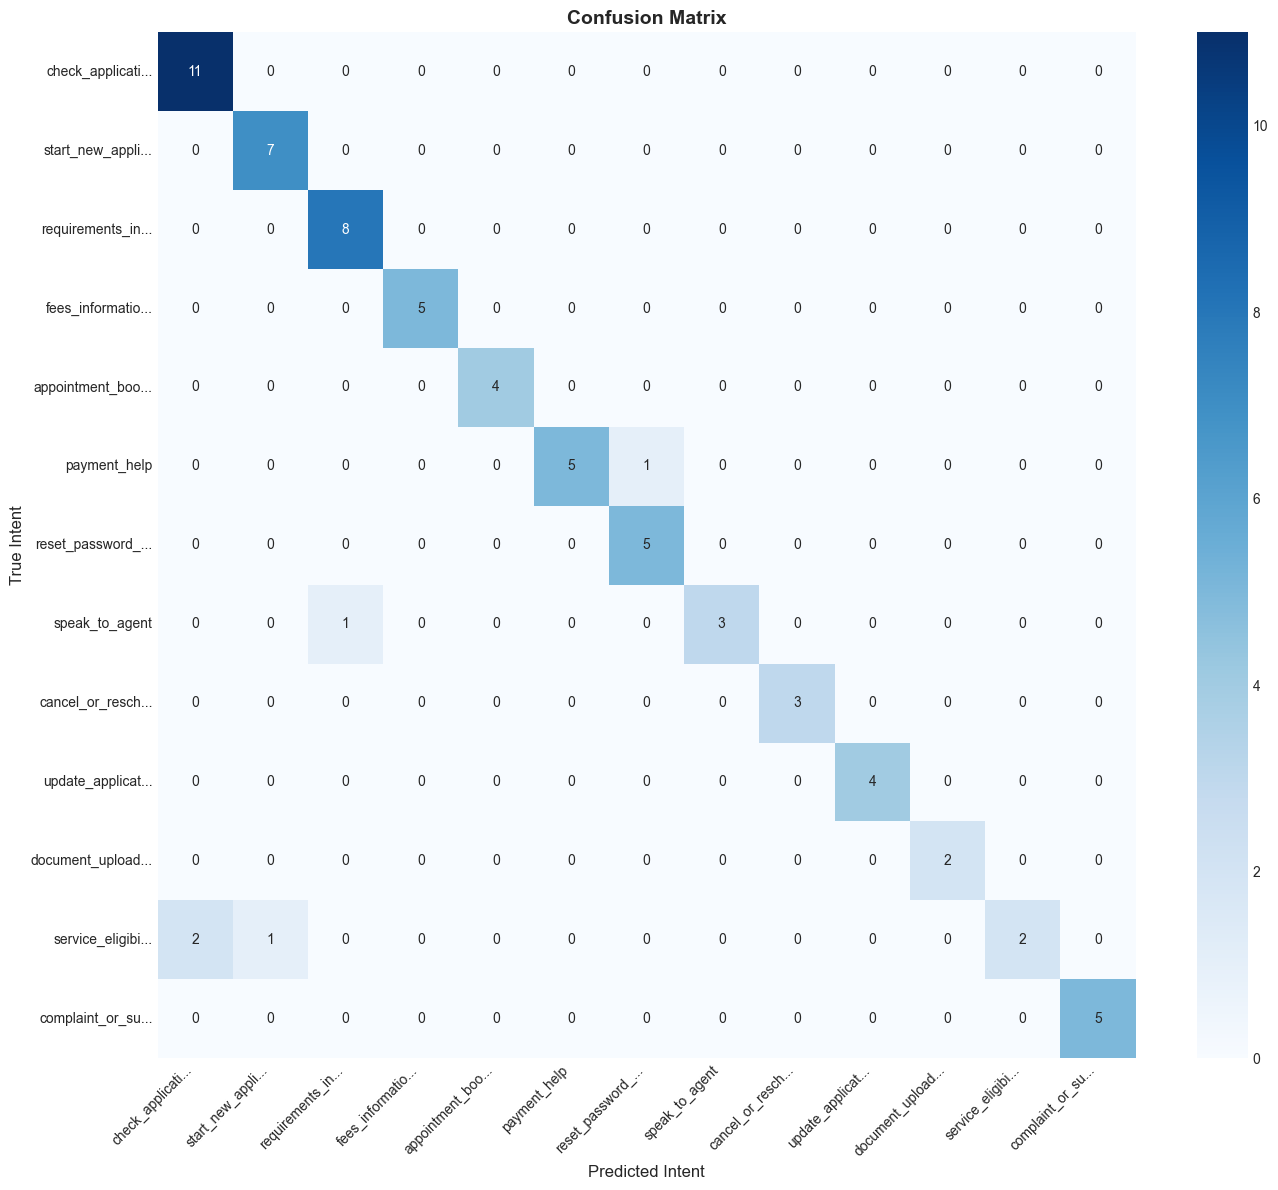


Most Confused Intent Pairs:
  service_eligibility -> check_application_status: 2 errors
  payment_help -> reset_password_login_help: 1 errors
  speak_to_agent -> requirements_information: 1 errors
  service_eligibility -> start_new_application: 1 errors


In [22]:
# Plot confusion matrix
fig, ax = plt.subplots(figsize=(14, 12))

# Abbreviate intent names for display
short_names = [name[:15] + '...' if len(name) > 15 else name for name in label_encoder.intents]

sns.heatmap(
    report.confusion_matrix, 
    annot=True, 
    fmt='d', 
    cmap='Blues',
    xticklabels=short_names,
    yticklabels=short_names,
    ax=ax
)
ax.set_xlabel('Predicted Intent', fontsize=12)
ax.set_ylabel('True Intent', fontsize=12)
ax.set_title('Confusion Matrix', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('../outputs/plots/confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

# Most confused pairs
print("\nMost Confused Intent Pairs:")
confused = get_confused_pairs(report.confusion_matrix, label_encoder.intents, top_k=5)
for true_int, pred_int, count in confused:
    print(f"  {true_int} -> {pred_int}: {count} errors")

## 5. Per-Language Performance

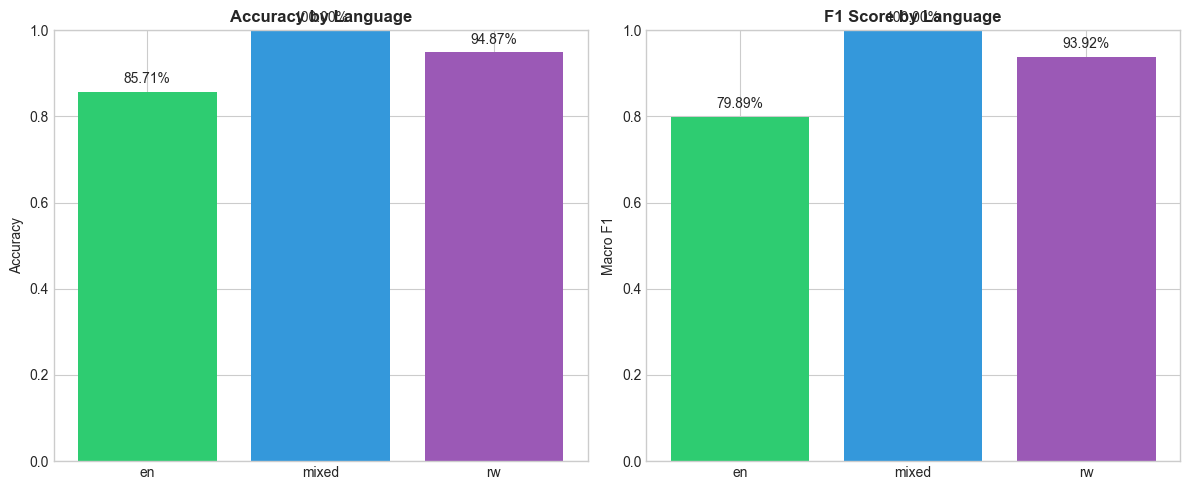


Language Performance Summary:
  en: Accuracy=85.71%, F1=79.89%
  mixed: Accuracy=100.00%, F1=100.00%
  rw: Accuracy=94.87%, F1=93.92%


In [23]:
# Language-stratified performance
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Accuracy by language
lang_acc = report.per_language_accuracy
axes[0].bar(lang_acc.keys(), lang_acc.values(), color=['#2ecc71', '#3498db', '#9b59b6'])
axes[0].set_ylabel('Accuracy')
axes[0].set_title('Accuracy by Language', fontweight='bold')
axes[0].set_ylim(0, 1)
for i, (lang, acc) in enumerate(lang_acc.items()):
    axes[0].text(i, acc + 0.02, f'{acc:.2%}', ha='center')

# F1 by language
lang_f1 = report.per_language_f1
axes[1].bar(lang_f1.keys(), lang_f1.values(), color=['#2ecc71', '#3498db', '#9b59b6'])
axes[1].set_ylabel('Macro F1')
axes[1].set_title('F1 Score by Language', fontweight='bold')
axes[1].set_ylim(0, 1)
for i, (lang, f1) in enumerate(lang_f1.items()):
    axes[1].text(i, f1 + 0.02, f'{f1:.2%}', ha='center')

plt.tight_layout()
plt.savefig('../outputs/plots/language_performance.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nLanguage Performance Summary:")
for lang in lang_acc.keys():
    print(f"  {lang}: Accuracy={lang_acc[lang]:.2%}, F1={lang_f1[lang]:.2%}")

## 6. Confidence Analysis

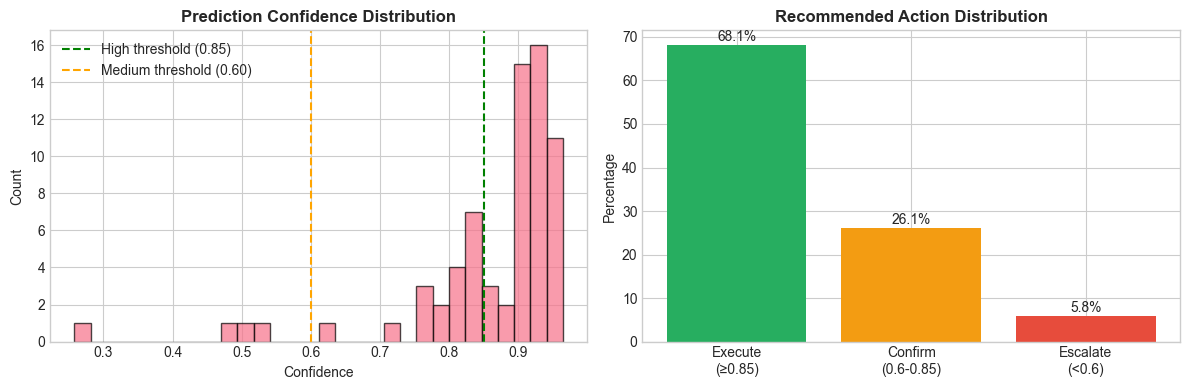


Confidence Statistics:
  Mean: 0.862
  Std: 0.124
  Median: 0.910

  Action Distribution:
    Execute (high conf): 68.1%
    Confirm (medium): 26.1%
    Escalate (low): 5.8%


In [24]:
from src.inference.confidence import analyze_confidence_distribution, ConfidenceThresholds

# Analyze confidence distribution
conf_analysis = analyze_confidence_distribution(confidences)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Confidence distribution
axes[0].hist(confidences, bins=30, edgecolor='black', alpha=0.7)
axes[0].axvline(0.85, color='green', linestyle='--', label='High threshold (0.85)')
axes[0].axvline(0.60, color='orange', linestyle='--', label='Medium threshold (0.60)')
axes[0].set_xlabel('Confidence')
axes[0].set_ylabel('Count')
axes[0].set_title('Prediction Confidence Distribution', fontweight='bold')
axes[0].legend()

# Action distribution
actions = ['Execute\n(≥0.85)', 'Confirm\n(0.6-0.85)', 'Escalate\n(<0.6)']
action_pcts = [
    conf_analysis['action_distribution']['execute_pct'],
    conf_analysis['action_distribution']['confirm_pct'],
    conf_analysis['action_distribution']['escalate_pct']
]
colors = ['#27ae60', '#f39c12', '#e74c3c']
axes[1].bar(actions, action_pcts, color=colors)
axes[1].set_ylabel('Percentage')
axes[1].set_title('Recommended Action Distribution', fontweight='bold')
for i, pct in enumerate(action_pcts):
    axes[1].text(i, pct + 1, f'{pct:.1f}%', ha='center')

plt.tight_layout()
plt.savefig('../outputs/plots/confidence_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nConfidence Statistics:")
print(f"  Mean: {conf_analysis['mean']:.3f}")
print(f"  Std: {conf_analysis['std']:.3f}")
print(f"  Median: {conf_analysis['median']:.3f}")
print(f"\n  Action Distribution:")
print(f"    Execute (high conf): {conf_analysis['action_distribution']['execute_pct']:.1f}%")
print(f"    Confirm (medium): {conf_analysis['action_distribution']['confirm_pct']:.1f}%")
print(f"    Escalate (low): {conf_analysis['action_distribution']['escalate_pct']:.1f}%")

## 7. Error Analysis

In [25]:
from src.evaluation.error_analysis import ErrorAnalyzer

# Create error analyzer
analyzer = ErrorAnalyzer(
    texts=texts,
    y_true=y_true,
    y_pred=y_pred,
    intent_names=label_encoder.intents,
    confidences=confidences,
    metadata=test_df
)

analyzer.print_report()


ERROR ANALYSIS REPORT

📊 Overall Statistics
----------------------------------------
  Total samples: 69
  Total errors: 5
  Error rate: 7.25%

🌍 Error Rate by Language
----------------------------------------
  en      : 14.29% (3/21)
  mixed   : 0.00% (0/9)
  rw      : 5.13% (2/39)

❌ Most Confused Intent Pairs
----------------------------------------
  service_eligibility
    → check_application_status
      Count: 2, Avg confidence: 0.56
      Example: "What are the eligibility rules for business regist..."
  service_eligibility
    → start_new_application
      Count: 1, Avg confidence: 0.26
      Example: "Ese gusimbuza indangamuntu iba isabwa n’abantu b’i..."
  payment_help
    → reset_password_login_help
      Count: 1, Avg confidence: 0.91
      Example: "Ntabasha kwinjira muri account yanjye...."
  speak_to_agent
    → requirements_information
      Count: 1, Avg confidence: 0.54
      Example: "Can I speak to customer support?..."

⚠️ High Confidence Errors (conf >= 0.8)
--

In [15]:
# Show specific error examples
print("\nSample Misclassifications:")
print("="*70)

for case in analyzer.error_cases[:5]:
    print(f"\nText: \"{case.text}\"")
    print(f"  Language: {case.language}")
    print(f"  True: {case.true_intent}")
    print(f"  Predicted: {case.predicted_intent}")
    print(f"  Confidence: {case.confidence:.2%}")


📝 Sample Misclassifications:

Text: "Ese gusimbuza indangamuntu iba isabwa n’abantu b’iki cyiciro?"
  Language: rw
  True: service_eligibility
  Predicted: start_new_application
  Confidence: 25.79%

Text: "Ntabasha kwinjira muri account yanjye."
  Language: rw
  True: payment_help
  Predicted: reset_password_login_help
  Confidence: 91.08%

Text: "Can I speak to customer support?"
  Language: en
  True: speak_to_agent
  Predicted: requirements_information
  Confidence: 53.56%

Text: "What are the eligibility rules for business registration?"
  Language: en
  True: service_eligibility
  Predicted: check_application_status
  Confidence: 61.52%

Text: "What are the eligibility rules for driving license?"
  Language: en
  True: service_eligibility
  Predicted: check_application_status
  Confidence: 51.08%


## 8. Summary

In [26]:
print("="*60)
print("EVALUATION SUMMARY")
print("="*60)

print(f"""
OVERALL PERFORMANCE:
   - Accuracy: {report.accuracy:.2%}
   - Macro F1: {report.macro_f1:.2%}
   - Weighted F1: {report.weighted_f1:.2%}

LANGUAGE FAIRNESS:
   - English: {report.per_language_accuracy.get('en', 0):.2%} accuracy
   - Kinyarwanda: {report.per_language_accuracy.get('rw', 0):.2%} accuracy
   - Mixed: {report.per_language_accuracy.get('mixed', 0):.2%} accuracy

CONFIDENCE CALIBRATION:
   - Mean confidence: {report.mean_confidence:.2%}
   - ECE (Expected Calibration Error): {report.ece:.4f}

ERROR ANALYSIS:
   - Total errors: {analyzer.num_errors} ({analyzer.error_rate:.2%})
   - High confidence errors: {len(analyzer.get_high_confidence_errors())}

PRODUCTION READINESS:
   - {conf_analysis['action_distribution']['execute_pct']:.1f}% predictions can be auto-executed
   - {conf_analysis['action_distribution']['escalate_pct']:.1f}% require human escalation
""")

print("="*60)
print("Evaluation Complete!")
print("\nPlots saved to: ../outputs/plots/")

EVALUATION SUMMARY

OVERALL PERFORMANCE:
   - Accuracy: 92.75%
   - Macro F1: 92.60%
   - Weighted F1: 91.93%

LANGUAGE FAIRNESS:
   - English: 85.71% accuracy
   - Kinyarwanda: 94.87% accuracy
   - Mixed: 100.00% accuracy

CONFIDENCE CALIBRATION:
   - Mean confidence: 86.22%
   - ECE (Expected Calibration Error): 0.1209

ERROR ANALYSIS:
   - Total errors: 5 (7.25%)
   - High confidence errors: 1

PRODUCTION READINESS:
   - 68.1% predictions can be auto-executed
   - 5.8% require human escalation

Evaluation Complete!

Plots saved to: ../outputs/plots/
